# Drug Discovery using ChEMBL

ChEMBL is a curated chemical database of **bioactive molecules** with drug-like properties. 

#### Table of contents

1.   [Preliminary research phase](#Research)
2.   [Acquire & prepare molecular data](#Acquire)
3.   [Explore molecular descriptors](#Explore)
4.   [Modeling the chemical fingerprints](#Model)



In [1]:
import pandas as pd
import numpy as np
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from source.prepare import preprocess_bioactivity_data
from source.model_m import *

%load_ext autoreload
%autoreload 2

<a id='Research'></a>
## 1. Preliminary research phase


In October, 2021, [*Nature* reported](https://www.nature.com/articles/d41586-021-02755-5#ref-CR2), `More than 130 years after the naming of the Plasmodium parasites behind malaria, the world now has its first approved vaccine against them ... Compared with other childhood vaccinations, RTS,S has only modest efficacy, preventing about 30% of severe malaria cases after a series of four injections in children under the age of five. Nevertheless, one modelling study suggests that it could prevent the deaths of 23,000 children a year ... [malaria] killed 411,000 people in 2018.`

Accoring to the [CDC website](https://www.cdc.gov/malaria/about/biology/index.html#tabs-1-6), `Four species of Plasmodium have long been recognized to infect humans in nature. In addition there is one species that naturally infects macaques which has recently been recognized to be a cause of zoonotic malaria in humans ... P. knowlesi is found throughout Southeast Asia as a natural pathogen of long-tailed and pig-tailed macaques. It has a 24-hour replication cycle and so can rapidly progress from an uncomplicated to a severe infection; fatal cases have been reported.`

![](https://www.cdc.gov/malaria/images/microscopy/about/falciparum.jpg)

(P. falciparum, the deadliest species targeted by new vaccine)

![](https://www.cdc.gov/malaria/images/microscopy/about/knowlesi.jpg)

(P. knowlesi, newly found to cause zoonotic malaria in humans infected by primates)

Is [Plasmodium knowlesi](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL613011/) in the ChEMBL database? If so, we can use it to retrieve the microorganism's assays, which are chemical tests made to estimate the **potency** of sample compounds on the organism. We can check using the ChEMBL group's official Python client library... 

In [2]:
drug_target = 'Plasmodium knowlesi'

target_dicts = []
res = new_client.target.search(drug_target)
for r in res:
    target_dicts.append({'organism': r['organism'],
                         'pref_name': r['pref_name'],
                         'target_chembl_id': r['target_chembl_id']})
#top result
target_dicts[0]

{'organism': 'Plasmodium knowlesi',
 'pref_name': 'Plasmodium knowlesi',
 'target_chembl_id': 'CHEMBL613011'}

<a id='Acquire'></a>
## 2. Acquire & prepare molecular data

This cell will create **two csv files** based on the TARGET_ID:

* preprocessed data with SMILES notation and added columns for Lapinski descriptors (drug-like properties), $pIC_{50}$ values (potency, the dependnt variable), and a binary class variable ('ACTIVE', 'INACTIVE') indicating whether or not each molecule is reactive with the target

* the chemical fingerprint, a 881-digit binary represntation of the molecular structure, for each molecule in the dataset that is used for training the machine learning algorithm to recognize promising new molecules

Dependencies include the ChEMBL Webresource Client, RDKit, and PaDELPy

In [3]:
target_id = target_dicts[0]['target_chembl_id']
preprocess_bioactivity_data(target_id, tests=True, fingerprints=True)


Query results retrieved for CHEMBL613011...
Saving 9 molecules.

Mann-Whitney U tests for molecular descriptors (active vs. inactive)...

 MW
   U statistic = 0, p = 0.013
   Different distribution. Reject H0.

 LogP
   U statistic = 6, p = 0.256
   Same distribution. Fail to reject H0.

 NumHDonors
   U statistic = 0, p = 0.010
   Different distribution. Reject H0.

 NumHAcceptors
   U statistic = 8, p = 0.319
   Same distribution. Fail to reject H0.

Computing fingerprints (takes several minutes if molecules > 1000)...
Success!



In [4]:
bioactivity_df = pd.read_csv(f'{target_id}_bioactivity_preprocessed.csv')
bioactivity_df

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL1951761,CCCCCCCCCCCCC[C@H](O)C[C@H](O)[C@H](C)N,10500.0,INACTIVE,301.515,4.14660,3.0,3.0,4.978811
1,CHEMBL1951763,CCCCCCCCCCCCC[C@H](O)C[C@@H](O)[C@H](C)N,20300.0,INACTIVE,301.515,4.14660,3.0,3.0,4.692504
2,CHEMBL1951762,CCCCCCCCCCCCC[C@@H](O)C[C@H](O)[C@H](C)N,17600.0,INACTIVE,301.515,4.14660,3.0,3.0,4.754487
3,CHEMBL76,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12,10.0,ACTIVE,319.880,4.81060,1.0,3.0,8.000000
4,CHEMBL172,O[C@@H](c1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12)[C@...,40.0,ACTIVE,378.316,4.44790,2.0,3.0,7.397940
5,CHEMBL4166227,Clc1cccc2c1-c1ccccc1[I+]2.O=S(=O)([O-])C(F)(F)F,80.0,ACTIVE,462.614,0.50020,0.0,3.0,7.096910
6,CHEMBL4174142,Fc1cccc2c1-c1ccccc1[I+]2.O=S(=O)([O-])C(F)(F)F,80.0,ACTIVE,446.159,-0.01410,0.0,3.0,7.096910
7,CHEMBL4165957,N#Cc1ccc2c(c1)-c1ccccc1[I+]2.O=S(=O)([O-])C(F)...,110.0,ACTIVE,453.179,-0.28152,0.0,4.0,6.958607
8,CHEMBL4167328,O=S(=O)([O-])C(F)(F)F.c1ccc2c(c1)[I+]c1ccccc1-2,740.0,ACTIVE,428.169,-0.15320,0.0,3.0,6.130768


In [5]:
fingerprint_df = pd.read_csv(f'{target_id}_pubchem_fp.csv')
fingerprint_df

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL1951763,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL1951761,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL76,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL1951762,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL4166227,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,CHEMBL172,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,CHEMBL4174142,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,CHEMBL4165957,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,CHEMBL4167328,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Three representations of molecule CHEMBL76



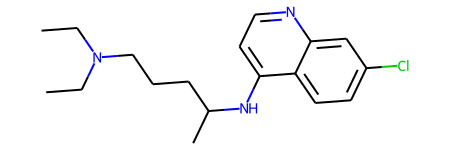

In [6]:
mol = 'CHEMBL76'
SMILES = bioactivity_df.canonical_smiles[bioactivity_df.molecule_chembl_id==mol].values[0]
fingerprint = np.array(fingerprint_df[fingerprint_df.Name==mol])[0][1:]

print(f'Three representations of molecule {mol}\n')
Chem.MolFromSmiles(SMILES) #an example molecule

In [7]:
print('2. SMILES notation:', SMILES)
print('3. Chemical fingerprint:')
print(fingerprint)

2. SMILES notation: CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12
3. Chemical fingerprint:
[1 1 1 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 1 0 0 1 0 0 0 0
 1 1 1 1 1 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 1 1 0
 0 1 1 1 0 1 0 0 0 1 

<a id='Explore'></a>
## 3. Explore molecular descriptors

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (5,5)
plt.style.use('fivethirtyeight')

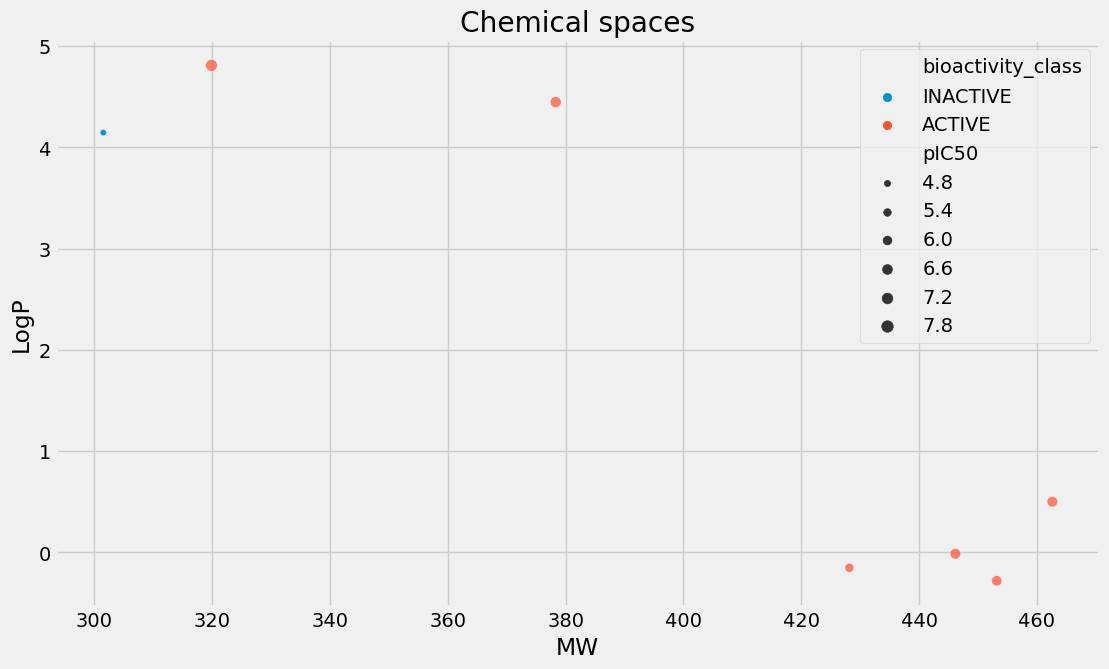

In [9]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x='MW', y='LogP', data=bioactivity_df, hue='bioactivity_class', size='pIC50', alpha=.7)
plt.legend(bbox_to_anchor=(1,1))
plt.title('Chemical spaces')
plt.show()

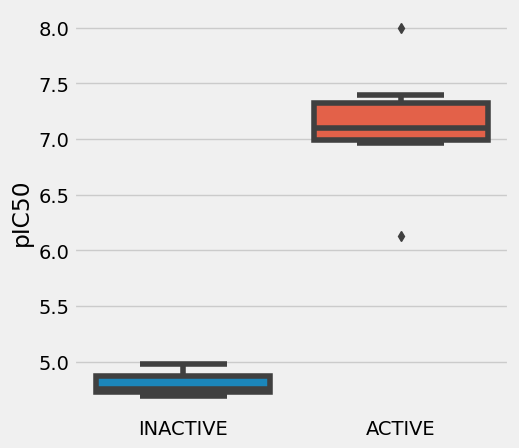

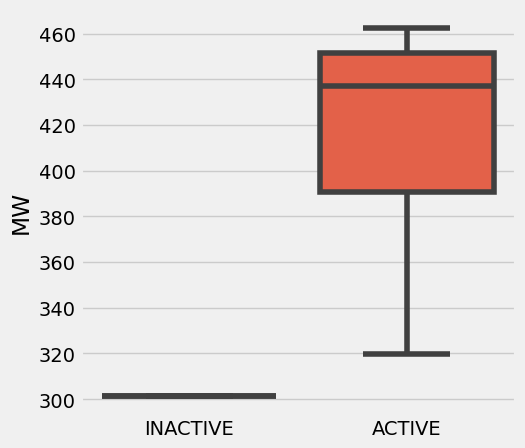

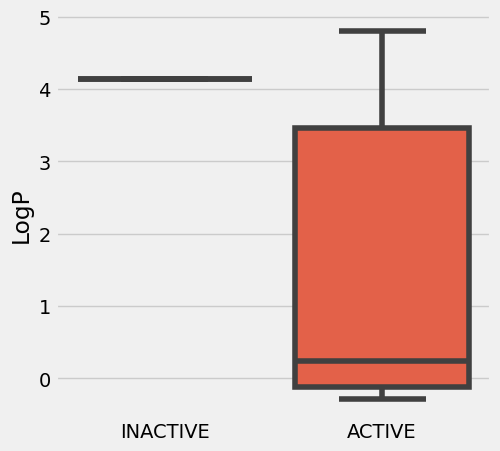

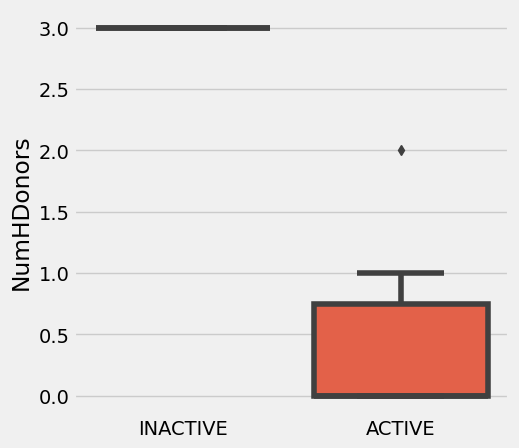

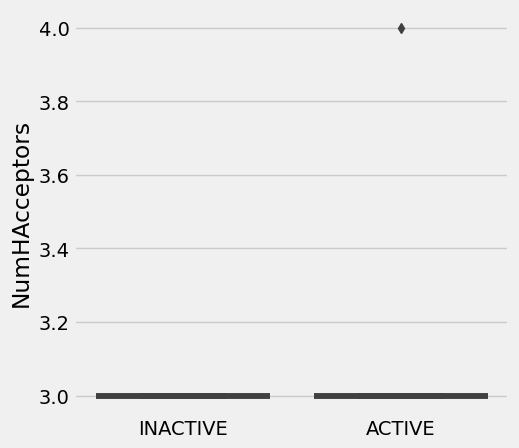

In [10]:
for column in ['pIC50', 'MW', 'LogP', 'NumHDonors', 'NumHAcceptors']:
    sns.boxplot(x='bioactivity_class', y=column, data=bioactivity_df)
    plt.xlabel('')
    plt.show()

<a id='Model'></a>
## 4. Modeling the chemical fingerprints

In this part, we use machine learning to determine the charchteristics of molecules with a high chance of being viable drug candidates.

A note on modeling: $R^2$ is the percent of the variance in [potency](https://en.wikipedia.org/wiki/Potency_(pharmacology)) (as measured by $pIC_{50}$) is explained by the chemical fingerprint of the molecule.

In [62]:
modeling_df, target = premodeling_processing(bioactivity_df, fingerprint_df)

In [111]:
modeling_df.head()

,molecule_id,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL1951763,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,301.515,4.1466,3.0,3.0
1,CHEMBL1951761,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,301.515,4.1466,3.0,3.0
2,CHEMBL76,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,319.880,4.8106,1.0,3.0
3,CHEMBL1951762,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,301.515,4.1466,3.0,3.0
4,CHEMBL4166227,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,462.614,0.5002,0.0,3.0


In [112]:
target

,pIC50,bioactivity_class,standard_value
0,4.692504,0,20300.0
1,4.978811,0,10500.0
2,8.000000,1,10.0
3,4.754487,0,17600.0
4,7.096910,1,80.0
5,7.397940,1,40.0
6,7.096910,1,80.0
7,6.958607,1,110.0
8,6.130768,1,740.0


In [145]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

In [155]:
names = ['Random Forrest', 'Linear Regressor']
models = [RandomForestRegressor(), LinearRegression()]

In [156]:
model_obj = Modeling_class(modeling_df, target, models, names)

In [160]:
avg_scores, scores, outputs = model_obj.regression_modeling(splits = 2)

Scaling has already been run, moving on to modeling, this may take a while...
Modeling done!


In [161]:
outputs

[{'fit_time': array([0.11978602, 0.11977696]),
  'score_time': array([0.01338506, 0.01347899]),
  'estimator': [RandomForestRegressor(), RandomForestRegressor()],
  'test_neg_root_mean_squared_error': array([-0.56721356, -1.0217896 ]),
  'test_r2': array([0.78152398, 0.40982517])},
 {'fit_time': array([0.00760412, 0.00782776]),
  'score_time': array([0.0063827 , 0.00621319]),
  'estimator': [LinearRegression(), LinearRegression()],
  'test_neg_root_mean_squared_error': array([-0.26624516, -0.64046622]),
  'test_r2': array([0.95186356, 0.768127  ])}]

In [162]:
pd.DataFrame.from_dict(avg_scores)

,model_type,metric,avg_score
0,RandomForestRegressor(),neg_root_mean_squared_error,[0.7945]
1,RandomForestRegressor(),r2,[0.596]
2,LinearRegression(),neg_root_mean_squared_error,[0.453]
3,LinearRegression(),r2,[0.86]


In [163]:
pd.DataFrame.from_dict(scores)

,model_type,metric,scores
0,RandomForestRegressor(),neg_root_mean_squared_error,"[[0.567, 1.022]]"
1,RandomForestRegressor(),r2,"[[0.782, 0.41]]"
2,LinearRegression(),neg_root_mean_squared_error,"[[0.266, 0.64]]"
3,LinearRegression(),r2,"[[0.952, 0.768]]"


In [135]:
model_obj.df

,molecule_id,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL1951763,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,301.515,4.14660,3.0,3.0
1,CHEMBL1951761,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,301.515,4.14660,3.0,3.0
2,CHEMBL76,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,319.880,4.81060,1.0,3.0
3,CHEMBL1951762,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,301.515,4.14660,3.0,3.0
4,CHEMBL4166227,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,462.614,0.50020,0.0,3.0
5,CHEMBL172,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,378.316,4.44790,2.0,3.0
6,CHEMBL4174142,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,446.159,-0.01410,0.0,3.0
7,CHEMBL4165957,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,453.179,-0.28152,0.0,4.0
8,CHEMBL4167328,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,428.169,-0.15320,0.0,3.0


In [136]:
model_obj.scaled_df

,MW,LogP,NumHDonors,NumHAcceptors,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,0.000000,0.869602,1.000000,0.0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.000000,0.869602,1.000000,0.0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.113998,1.000000,0.333333,0.0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.000000,0.869602,1.000000,0.0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.000000,0.153516,0.000000,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0.476732,0.928772,0.666667,0.0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0.897858,0.052516,0.000000,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0.941434,0.000000,0.000000,1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0.786187,0.025200,0.000000,0.0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
rfr = RandomForestRegressor(n_estimators=100, ccp_alpha=.01, random_state=36)
ols = LinearRegression()
lars = LassoLars()
twee = TweedieRegressor()
poly = PolynomialFeatures()

In [7]:
type(rfr), type(ols), type(lars), type(twee), type(poly)

(sklearn.ensemble._forest.RandomForestRegressor,
 sklearn.linear_model._base.LinearRegression,
 sklearn.linear_model._least_angle.LassoLars,
 sklearn.linear_model._glm.glm.TweedieRegressor,
 sklearn.preprocessing._data.PolynomialFeatures)

In [ ]:
selector = VarianceThreshold(.1)
X = selector.fit_transform(fingerprints.iloc[:,1:])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=36)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

We've already dropped features with low variance (under 0.1) thereby reducing the fingerprint from 881 to 100-200 features. Now try to maximize the cross-validation score.
